## 2020707035 박시언 homework #7: reinforcement learning

### Q-iteration
- q-iteration은 환경을 미리 알고 있어야 한다. 해당 환경에서 발만 방정식을 통해 Q를 계산한다.또한 전이확률을 알아야 한다. 이는 현재 state에서 action을 취할 확률을 모두 알고있어야 한다는 말이다.
이를 model based 하다고 말한다.

### Q-learning
- q-learning은 전이확률을 몰라도 된다. 직접 환경과 상호작용 하면서 최적의 reward를 그리디하게 찾아 Q-value를 업데이트 한다. 이는 behavior policy와 target policy가 다르기에 off policy라 불린다.

Q-learning은 미래를 고려하지 않고 현재의 s에서 최적의 reward를 받는 a를 선택한다.

### SARSA
- SARSA는 onpolicy다. 입실론 값에 따라 q-learning에 비해 덜 그리디하게 탐색을 한다. 즉, q-value를 업데이트 하는데 최적의 action이 아닌 값을 선택하여 업데이트 할 수 있다는 의미이다.



Q-Iteration Results:


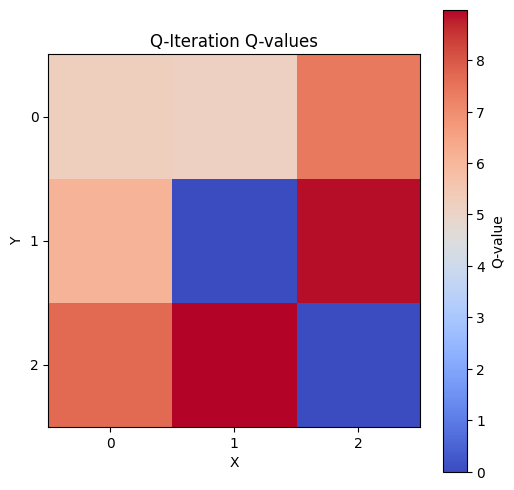


Q-Learning Results:


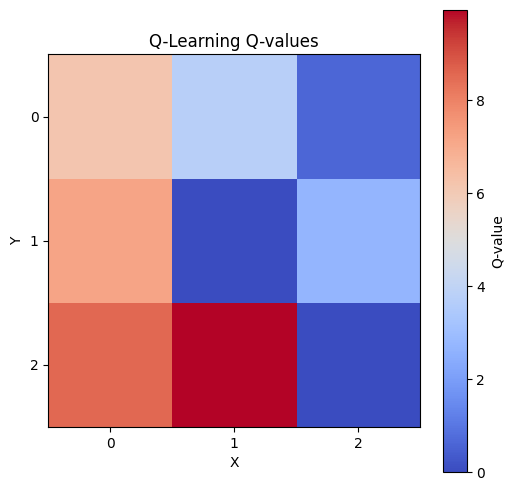


SARSA Results:


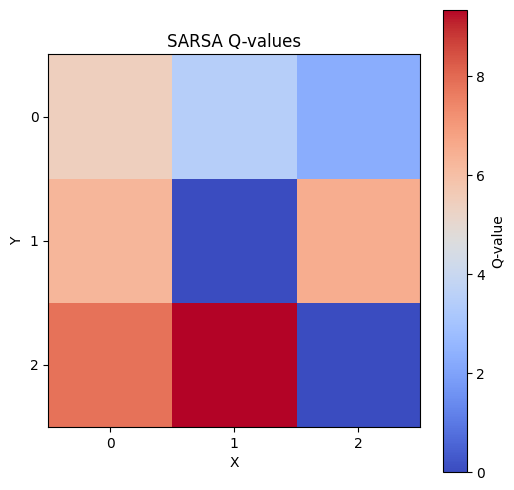

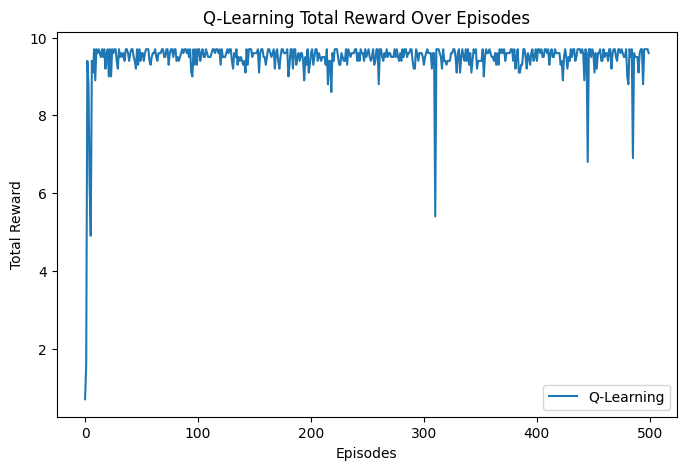

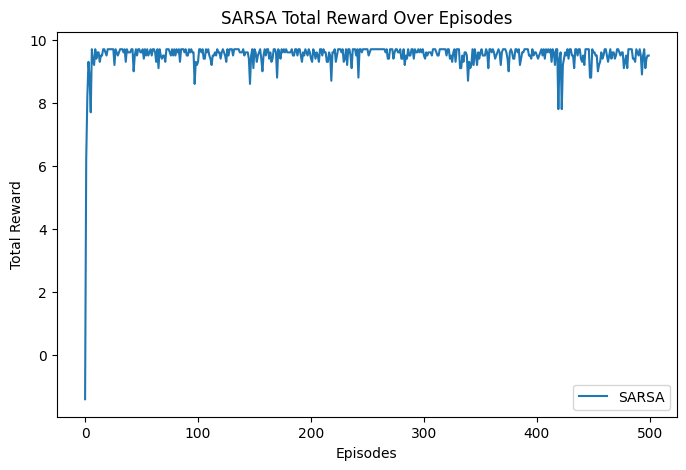

In [9]:
import numpy as np
import random
import matplotlib.pyplot as plt


# 1. Grid World 환경 정의
def initialize_grid():
    start = (0, 0)  # 시작 지점
    goal = (2, 2)  # 목표 지점
    penalty = (0, 2)  # 패널티 지점
    obstacle = (1, 1)  # 장애물
    actions = ['up', 'down', 'left', 'right']  # 행동 공간
    return start, goal, penalty, obstacle, actions


def step(state, action, goal, penalty, obstacle, actions, transition_prob):
    if state == goal:
        return state, 10, True

    x, y = state
    intended_next = move(x, y, action)
    actual_next = apply_transition(intended_next, x, y, actions, obstacle, transition_prob)

    if actual_next == goal:
        return actual_next, 10, True
    elif actual_next == penalty:
        return actual_next, -1, False
    else:
        return actual_next, -0.1, False


def move(x, y, action):
    if action == 'up':
        return max(0, x - 1), y
    elif action == 'down':
        return min(2, x + 1), y
    elif action == 'left':
        return x, max(0, y - 1)
    elif action == 'right':
        return x, min(2, y + 1)


def apply_transition(intended, x, y, actions, obstacle, transition_prob):
    if random.random() < transition_prob:
        next_state = intended
    else:
        next_state = move(x, y, random.choice(actions))
    return (x, y) if next_state == obstacle else next_state


# 2. Q-Iteration 구현
def q_iteration(states, actions, gamma, transition_prob, rewards, goal, obstacle, threshold=1e-4):
    Q = {state: {action: 0 for action in actions} for state in states}
    delta = float('inf')

    while delta > threshold:
        delta = 0
        Q_new = {state: Q[state].copy() for state in Q}

        for state in Q:
            if state == goal:  # 목표 상태는 업데이트하지 않음
                continue

            for action in actions:
                intended_next = move(state[0], state[1], action)
                unintended_next = [move(state[0], state[1], a) for a in actions if a != action]

                # 장애물 상태 제외
                unintended_next = [s for s in unintended_next if s != obstacle]

                # Q 값 참조 시 기본값 제공
                intended_value = max(Q.get(intended_next, {a: 0 for a in actions}).values())
                unintended_values = [
                    max(Q.get(next_state, {a: 0 for a in actions}).values())
                    for next_state in unintended_next
                ]

                # 예상 가치 계산
                expected_value = (
                        transition_prob * (rewards.get(intended_next, -0.1) + gamma * intended_value) +
                        (1 - transition_prob) / 3 * sum(
                    rewards.get(next_state, -0.1) + gamma * val
                    for next_state, val in zip(unintended_next, unintended_values)
                )
                )

                Q_new[state][action] = expected_value
                delta = max(delta, abs(Q[state][action] - Q_new[state][action]))

        Q = Q_new
    return Q


# 3. Q-Learning 구현 (총 보상 추적 추가)
def q_learning(states, actions, episodes, alpha, epsilon, gamma, rewards, goal, penalty, obstacle, transition_prob):
    Q = np.zeros((3, 3, len(actions)))
    total_rewards = []  # 총 보상 추적 리스트

    for episode in range(episodes):
        state = (0, 0)
        done = False
        episode_reward = 0  # 에피소드 동안의 총 보상

        while not done:
            if random.random() < epsilon:
                action = random.choice(range(len(actions)))
            else:
                action = np.argmax(Q[state[0], state[1]])

            next_state, reward, done = step(state, actions[action], goal, penalty, obstacle, actions, transition_prob)
            episode_reward += reward

            best_next_action = np.argmax(Q[next_state[0], next_state[1]])
            Q[state[0], state[1], action] += alpha * (
                    reward + gamma * Q[next_state[0], next_state[1], best_next_action] -
                    Q[state[0], state[1], action]
            )
            state = next_state

        total_rewards.append(episode_reward)  # 에피소드별 총 보상 저장

    return Q, total_rewards


# 4. SARSA 구현 (총 보상 추적 추가)
def sarsa(states, actions, episodes, alpha, epsilon, gamma, rewards, goal, penalty, obstacle, transition_prob):
    Q = np.zeros((3, 3, len(actions)))
    total_rewards = []  # 총 보상 추적 리스트

    for episode in range(episodes):
        state = (0, 0)
        action = np.argmax(Q[state[0], state[1]]) if random.random() > epsilon else random.choice(range(len(actions)))
        done = False
        episode_reward = 0  # 에피소드 동안의 총 보상

        while not done:
            next_state, reward, done = step(state, actions[action], goal, penalty, obstacle, actions, transition_prob)
            episode_reward += reward

            next_action = np.argmax(Q[next_state[0], next_state[1]]) if random.random() > epsilon else random.choice(
                range(len(actions)))
            Q[state[0], state[1], action] += alpha * (
                    reward + gamma * Q[next_state[0], next_state[1], next_action] -
                    Q[state[0], state[1], action]
            )
            state, action = next_state, next_action

        total_rewards.append(episode_reward)  # 에피소드별 총 보상 저장

    return Q, total_rewards


# Total Reward 시각화 함수 (개별 그래프)
def plot_total_rewards_individual(rewards, label, title):
    plt.figure(figsize=(8, 5))
    plt.plot(rewards, label=label)
    plt.xlabel('Episodes')
    plt.ylabel('Total Reward')
    plt.title(title)
    plt.legend()
    plt.show()

# Q-values 시각화 함수
def plot_q_values(Q, title):
    q_values = np.max(Q, axis=2)  # 각 상태에서 최대 Q값을 가져옵니다.
    plt.figure(figsize=(6, 6))
    plt.imshow(q_values, cmap='coolwarm', interpolation='none')
    plt.colorbar(label='Q-value')
    plt.title(title)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.xticks(range(3))
    plt.yticks(range(3))
    plt.show()
    
# Q-Iteration Q-value 시각화 함수
def plot_q_iteration_values(Q, title):
    q_values = np.zeros((3, 3))
    for state in Q:
        if state != (1, 1):  # 장애물은 제외
            q_values[state[0], state[1]] = max(Q[state].values())
        else:
            q_values[state[0], state[1]] = np.nan  # 장애물은 NaN으로 처리

    plt.figure(figsize=(6, 6))
    plt.imshow(q_values, cmap='coolwarm', interpolation='none')
    plt.colorbar(label='Q-value')
    plt.title(title)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.xticks(range(3))
    plt.yticks(range(3))
    plt.show()


# 실행
start, goal, penalty, obstacle, actions = initialize_grid()
states = [(x, y) for x in range(3) for y in range(3) if (x, y) != (1, 1)]

# 보상 맵 생성
rewards = {goal: 10, penalty: -1}
for state in states:
    if state not in rewards:
        rewards[state] = -0.1

gamma = 0.9
transition_prob = 0.8
episodes = 500
alpha = 0.1
epsilon = 0.1

# Q-Iteration 실행
Q_iteration_result = q_iteration(states, actions, gamma, transition_prob, rewards, goal, obstacle)

# Q-Learning 실행 (총 보상 계산 추가)
q_learning_Q, q_learning_rewards = q_learning(
    states, actions, episodes, alpha, epsilon, gamma, rewards, goal, penalty, obstacle, transition_prob
)

# SARSA 실행 (총 보상 계산 추가)
sarsa_Q, sarsa_rewards = sarsa(
    states, actions, episodes, alpha, epsilon, gamma, rewards, goal, penalty, obstacle, transition_prob
)

# 결과 출력
print("\nQ-Iteration Results:")
plot_q_iteration_values(Q_iteration_result, "Q-Iteration Q-values")

print("\nQ-Learning Results:")
plot_q_values(q_learning_Q, "Q-Learning Q-values")

print("\nSARSA Results:")
plot_q_values(sarsa_Q, "SARSA Q-values")

# Total Reward 그래프 시각화 (개별 그래프)
plot_total_rewards_individual(q_learning_rewards, "Q-Learning", "Q-Learning Total Reward Over Episodes")
plot_total_rewards_individual(sarsa_rewards, "SARSA", "SARSA Total Reward Over Episodes")




In [6]:
# Q-Iteration 결과를 NumPy 배열로 변환
q_iter_Q = np.zeros((3, 3, len(actions)))
for state in states:
    for a, action in enumerate(actions):
        q_iter_Q[state[0], state[1], a] = Q_iteration_result[state].get(action, 0)

# Q-Iteration 정책 출력
print_policy(q_iter_Q, actions, "Q-Iteration")



Optimal Policy (Q-Iteration):
↓ → ↓
↓ X ↓
→ → ↑


In [7]:
# Q-Learning 정책 출력
print_policy(q_learning_Q, actions, "Q-Learning")

# SARSA 정책 출력
print_policy(sarsa_Q, actions, "SARSA")



Optimal Policy (Q-Learning):
↓ ← ←
↓ X ↓
→ → ↑

Optimal Policy (SARSA):
↓ ← ←
↓ X ↓
→ → ↑


q랑 v는 비슷한데 v는 해당 스테이트에서 기대되는 일정의 값이고, q는 action value 해당 스테이트에서 어떤 액션을 했을 때 받는 value
다인나믹 프로그래믹은 환경을 알 때고 이를 환경 베이스, 환경 모르면 모델 베이스, 모델 베이스면 어떤 a를 그냥 취하고 r, s'을 보고 테이블을 완성함
behaviour policy랑 target policy가 다르면 off policy=q-learning 같으면 on policy=sarsa

1-alfa : alfa가 0.7이면 현재 값에 0.3 만큼 유지
입실론 그리디 : 입실론 만큼 랜덤으로 선택
